In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import re
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

%matplotlib inline

In [ ]:
#Defining colour schemes to be used in the notebook for plotly plots
notebook_colours=["plum","slateblue","navy","firebrick","darksalmon","slateblue","maroon","lightskyblue","blue","darkmagenta"]
# setting plotly reused constants:
# colorshemes
continuous_color_scheme = px.colors.sequential.Sunset
discrete_color_scheme = px.colors.qualitative.Pastel1
# opacity
plots_opacity = 0.8

In [ ]:
# reading from csv to dataframe
root_path = '.'
df_fr = pd.read_csv(root_path + '/RideToMunichFridayevening.txt')
df_fr2 = pd.read_csv(root_path + '/NoahRideToMunichFridayEvening.txt')
df_st = pd.read_csv(root_path + '/RideToGarchingSaturdayMorning.txt')
df_st.columns = ['init_data']
df_st = df_st[:-1]

In [ ]:
pd.read_csv('FridayEveningToMF - Sheet1.csv')

,Upload,Download
count,2.000000,2.000000
mean,35.509500,0.772000
std,4.779335,1.091773
min,32.130000,0.000000
25%,33.819750,0.386000
50%,35.509500,0.772000
75%,37.199250,1.158000
max,38.889000,1.544000


In [ ]:
def CustomFileReader(filename_, line_begining='rudolfs@grey'):
  st_file_name = filename_
  st_file = list()

  with open(st_file_name, "r") as file:
      for line in file:
        is_new_line = line_begining in line
        if is_new_line:
          st_file.append(line)
        else:
          st_file[-1] = st_file[-1] + line
  return st_file

In [ ]:
df_st = CustomFileReader('RideToGarchingSaturdayMorning.txt')

In [ ]:
def ParseData(df_st,
              time_pattern = '[\d]+:[\d]+:[\d]+',
              downl_pattern = 'download capacity: ([\d]+\.[\d]*)',
              upl_pattern = 'upload capacity: ([\d]+\.[\d]+)'):
  df_size = len(df_st)

  download_speeds = [re.findall(downl_pattern, str(df_st[j])) for j in range(df_size)]
  #print("download_speeds: {}".format(download_speeds[:10]))
  download_speeds = [None if len(x) == 0 else float(x[0]) for x in download_speeds]

  upl_speeds = [re.findall(upl_pattern, str(df_st[j])) for j in range(df_size)]
  #print("upl_speeds: {}".format(upl_speeds[:10]))
  upl_speeds = [None if len(x) == 0 else float(x[0]) for x in upl_speeds]

  times = [re.findall(time_pattern, str(df_st[j]))[0] for j in range(df_size)]
  #print("time_pattern: {}".format(times[:10]))
  times = ['0' + x if len(x) < 8 else x for x in times] # add 0 if time is short str like 9:34:32 -> 09:34:32
  return times, download_speeds, upl_speeds


In [ ]:
times, download_speeds, upl_speeds = ParseData(df_st)
print(len(times))
print(len(download_speeds))
print(len(upl_speeds))
df_data0 = pd.DataFrame(list(zip(times, download_speeds, upl_speeds)), columns=['time', 'download_speed', 'upl_speed'])

163
163
163


In [ ]:
fig = px.line(df_data0, x="time", y="download_speed", title='download_speed')
fig.show()
fig = px.line(df_data0, x="time", y="upl_speed", title='upl_speed')
fig.show()

In [ ]:
df_data0 = df_data0.reset_index() # add some x-s
df_data0.head()

,level_0,index,time,download_speed,upl_speed
0,0,0,09:09:31,55.872,6.992
1,1,1,09:09:40,79.719,8.889
2,2,2,09:09:50,33.691,3.380
3,3,3,09:10:00,106.620,9.082
4,4,4,09:10:10,98.294,8.999


In [ ]:
df_data0[df_data0['download_speed'] >= 0] # return all non nulls

,level_0,index,time,download_speed,upl_speed
0,0,0,09:09:31,55.872,6.992
1,1,1,09:09:40,79.719,8.889
2,2,2,09:09:50,33.691,3.380
3,3,3,09:10:00,106.620,9.082
4,4,4,09:10:10,98.294,8.999
...,...,...,...,...,...
158,158,158,09:31:05,6.913,0.000
159,159,159,09:31:10,49.906,6.853
160,160,160,09:31:16,92.027,8.505
161,161,161,09:31:20,73.239,7.439


In [ ]:
# constraints on coefff?
# degree should be even? even 
d_non_null_data = df_data0[df_data0['download_speed'] >= 0]

pp = np.polyfit(range(d_non_null_data.shape[0]), d_non_null_data['download_speed'], deg=12)
#print(pp)
p = np.poly1d(pp)
print(p)
predicted_points = [p(x) for x in range(df_data0.shape[0])]
predicted_points[:10]
pred_down_df = pd.DataFrame(list(zip(range(len(predicted_points)), predicted_points)))
pred_down_df.head()

           12             11             10             9             8
4.484e-19 x  - 4.294e-16 x  + 1.802e-13 x  - 4.351e-11 x + 6.671e-09 x
              7             6            5           4          3
 - 6.763e-07 x + 4.575e-05 x - 0.002034 x + 0.05696 x - 0.9221 x
          2
 + 7.221 x - 16.61 x + 71.36


,0,1
0,0,71.363016
1,1,61.111032
2,2,60.508513
3,3,65.791820
4,4,74.142134


In [ ]:
import plotly.graph_objects as go

fig1 = px.scatter(df_data0[:150].rename(columns={'index' : 'timepoints'}), x='timepoints', y='download_speed', title='Approximating data' )
fig2 = px.line(pred_down_df[:150], x=0, y=1)

fig = go.Figure(data = fig1.data + fig2.data)
fig.show()

In [ ]:
print(p_over_thr(0))
p_over_thr(150)

1.3630156502999569


-9.143198307728606e+27

In [ ]:
pp

array([ 4.48389268e-19, -4.29370415e-16,  1.80186603e-13, -4.35071518e-11,
        6.67116088e-09, -6.76327250e-07,  4.57509308e-05, -2.03404356e-03,
        5.69597765e-02, -9.22100918e-01,  7.22145072e+00, -1.66063043e+01,
        7.13630157e+01])

In [ ]:
# solve equation poly - theshold = 0
# Python function returning a number. f must be continuous, and f(a) and f(b) must have opposite signs.
THREASHOLD = 70
pp_over_thr = pp
pp_over_thr[-1] = pp_over_thr[-1] - THREASHOLD
p_over_thr = np.poly1d(pp_over_thr)
print(p_over_thr)

import scipy

print(scipy.optimize.brenth(p_over_thr, 0, 150))


In [ ]:
# if there is innterruption, another plot
df_cut = pred_down_df[:155]

# where we have interruptions???
for el in df_cut[df_cut[1] < THREASHOLD] [0]:
  print(el, end=',')

1,2,3,20,21,22,23,24,25,26,27,28,29,30,31,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,

In [ ]:
pred_down_df[4:21]

,0,1
4,4,74.142134
5,5,83.513165
6,6,92.482769
7,7,100.125928
8,8,105.906707
9,9,109.587070
10,10,111.150562
11,11,110.739069
12,12,108.601030
13,13,105.049608


In [ ]:
len(list(df_cut[1][4:20]))

16

In [ ]:
x_ = list(range(4, 20))
print(len(x_) + 2)
#len([3.5] + x_ + [19.3] )
len([THREASHOLD] + list(df_cut[1][4:20]) + [THREASHOLD])
#print([THREASHOLD] * (len(x_) + 2))

18


18

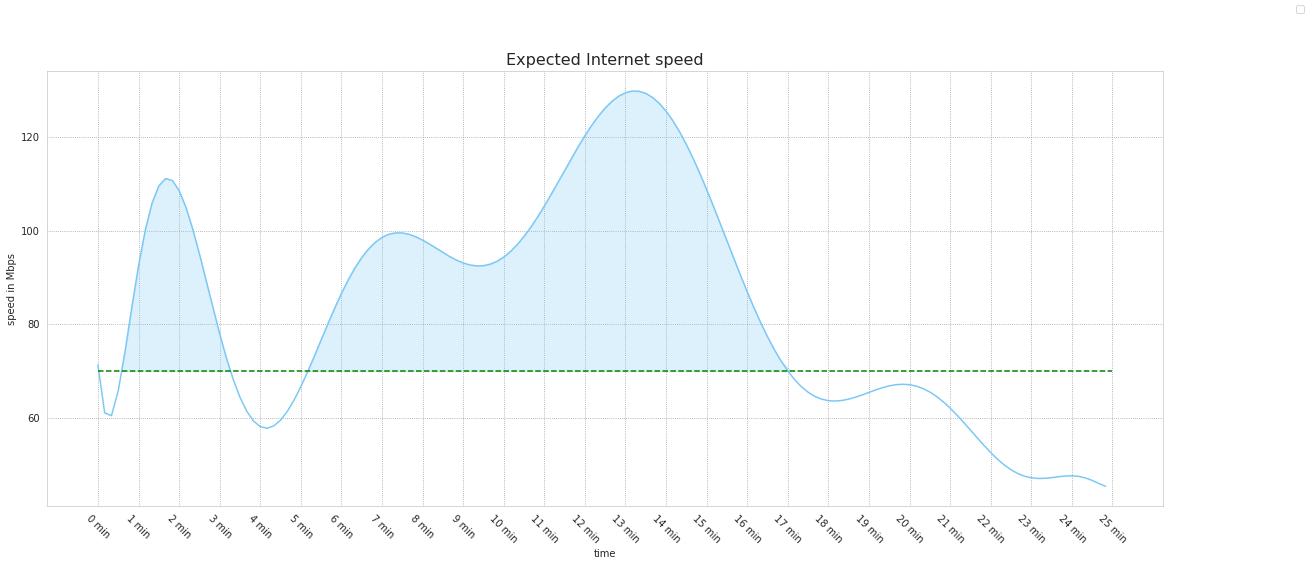

In [ ]:
df_cut = pred_down_df[:155]

sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})


fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
# sns.lineplot(data=df_data0, x='index', y='download_speed', color = 'darkturquoise')
sns.lineplot(data=pred_down_df[:150], x=0, y=1, color='#7BC8F6')# 4A639E

ax = sns.lineplot(x = [0, 150], y= [70, 70], color='green', dashes=True)

ax.lines[1].set_linestyle("--")

# x_ = range(0, 20)
# plt.fill_between(x = x_ , y1=pred_down_df[1][0:20], y2=[THREASHOLD] * len(x_))

x_ = list(range(4, 20))
plt.fill_between(x = ([3.5] + x_ + [19.5] ), 
                 y1= ([THREASHOLD] + list(df_cut[1][4:20]) + [THREASHOLD]) , 
                 y2=[THREASHOLD] * (len(x_) + 2), color = '#7BC8F640')


x_ = list(range(31, 102))
plt.fill_between(x = ([30.3] + x_ + [102.5] ), 
                 y1= ([THREASHOLD] + list(df_cut[1][31:102]) + [THREASHOLD]) , 
                 y2=[THREASHOLD] * (len(x_) + 2), color = '#7BC8F640')


plt.xticks(rotation = -45) 
plt.ylabel('speed in Mbps')
plt.xlabel('time')
start, end = ax.get_xlim()

ax.xaxis.set_ticks(np.arange(0, 150, 5))

#ax.xaxis.set_ticks([0, 18, 34]) # where you put ticks
#ax.set_xticklabels(['station1', 'stat2', 'st3']) # labels that you want to put
#ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']) # labels that you want to put
ax.xaxis.set_ticks(list(range(0, 155, 6)))
ax.set_xticklabels([ str(x) + ' min' for x in list(range(len(list(range(0, 155, 6)))))])
plt.title('Expected Internet speed', fontdict={'fontsize': 16})
fig.legend()
plt.show()

In [ ]:
# per min
15170 / 3 * 12

60680.0

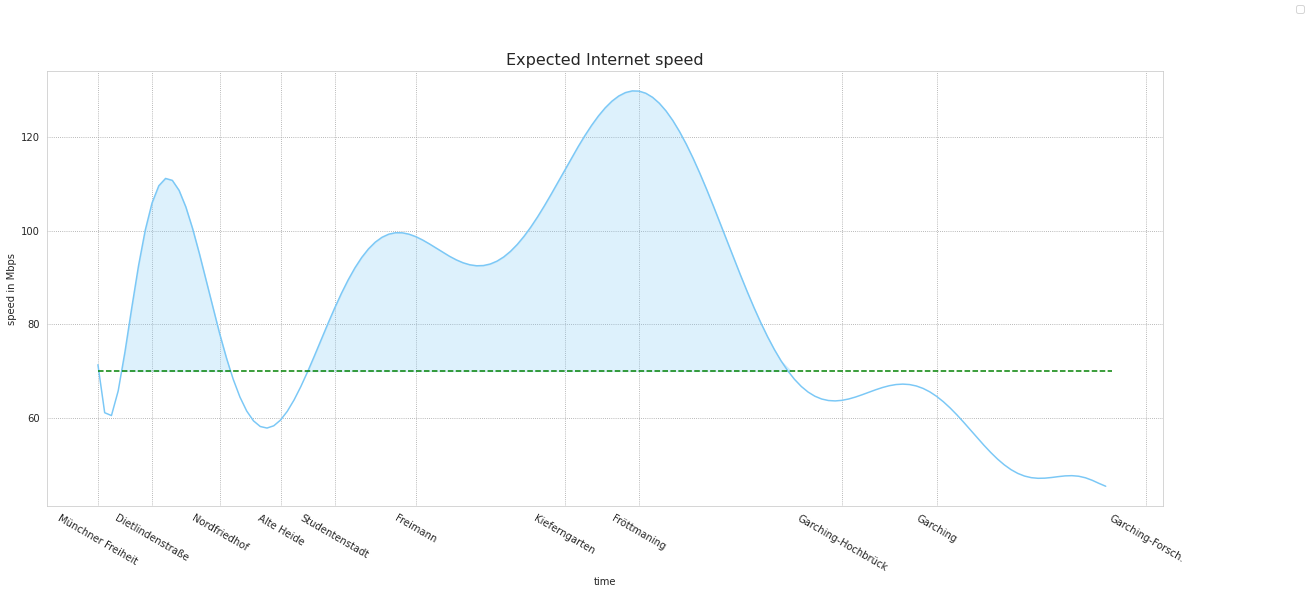

In [ ]:
df_cut = pred_down_df[:155]

sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})


fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
# sns.lineplot(data=df_data0, x='index', y='download_speed', color = 'darkturquoise')
sns.lineplot(data=pred_down_df[:150], x=0, y=1, color='#7BC8F6')# 4A639E

ax = sns.lineplot(x = [0, 150], y= [70, 70], color='green', dashes=True)

ax.lines[1].set_linestyle("--")

# x_ = range(0, 20)
# plt.fill_between(x = x_ , y1=pred_down_df[1][0:20], y2=[THREASHOLD] * len(x_))

x_ = list(range(4, 20))
plt.fill_between(x = ([3.5] + x_ + [19.5] ), 
                 y1= ([THREASHOLD] + list(df_cut[1][4:20]) + [THREASHOLD]) , 
                 y2=[THREASHOLD] * (len(x_) + 2), color = '#7BC8F640')


x_ = list(range(31, 102))
plt.fill_between(x = ([30.3] + x_ + [102.5] ), 
                 y1= ([THREASHOLD] + list(df_cut[1][31:102]) + [THREASHOLD]) , 
                 y2=[THREASHOLD] * (len(x_) + 2), color = '#7BC8F640')


plt.xticks(rotation = -30) 
plt.ylabel('speed in Mbps')
plt.xlabel('time')
start, end = ax.get_xlim()

ax.xaxis.set_ticks(np.arange(0, 150, 5))

ax.xaxis.set_ticks([0, 8, 18, 27, 35, 47, 69, 80, 110, 124, 155]) # where you put ticks
#ax.set_xticklabels(['station1', 'stat2', 'st3']) # labels that you want to put
ax.set_xticklabels(['Münchner Freiheit','Dietlindenstraße','Nordfriedhof','Alte Heide','Studentenstadt','Freimann','Kieferngarten','Fröttmaning','Garching-Hochbrück','Garching','Garching-Forsch.']) # labels that you want to put
#ax.xaxis.set_ticks(list(range(0, 155, 6)))
#ax.set_xticklabels([ str(x) + ' min' for x in list(range(len(list(range(0, 155, 6)))))])
plt.title('Expected Internet speed', fontdict={'fontsize': 16})
fig.legend()
plt.show()

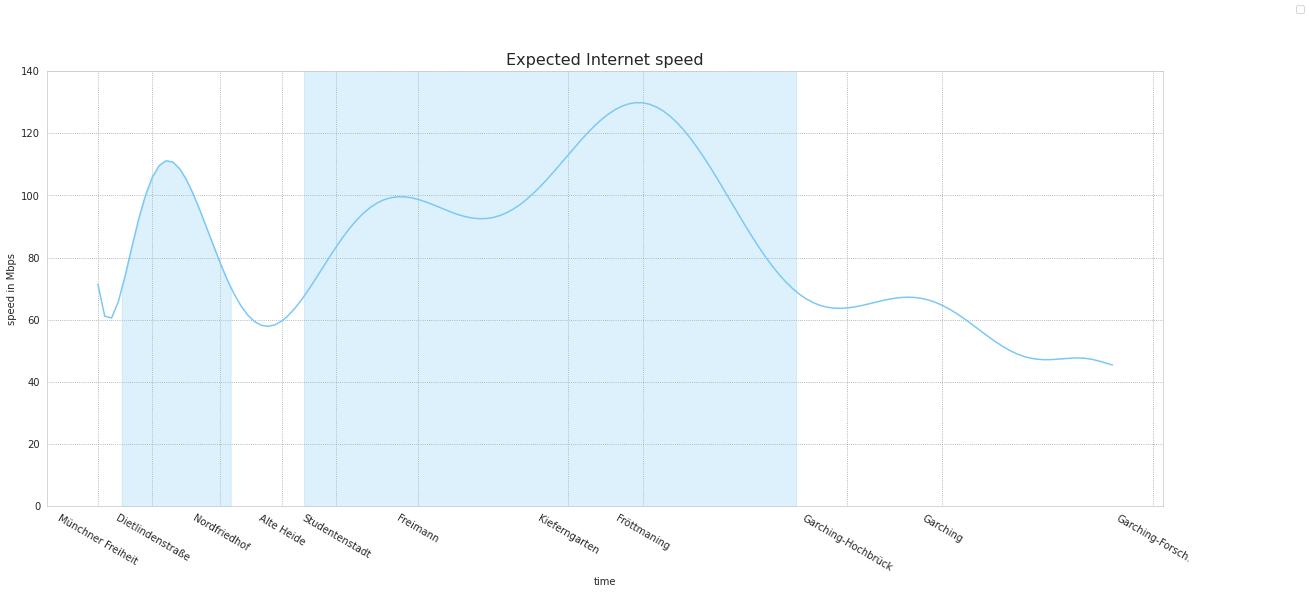

In [ ]:
df_cut = pred_down_df[:155]

sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})


fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
# sns.lineplot(data=df_data0, x='index', y='download_speed', color = 'darkturquoise')
sns.lineplot(data=pred_down_df[:150], x=0, y=1, color='#7BC8F6')# 4A639E

#ax = sns.lineplot(x = [0, 150], y= [70, 70], color='green', dashes=True)

#ax.lines[1].set_linestyle("--")

# x_ = range(0, 20)
# plt.fill_between(x = x_ , y1=pred_down_df[1][0:20], y2=[THREASHOLD] * len(x_))

x_ = list(range(4, 20))
plt.fill_between(x = ([3.5] + x_ + [19.5] ), 
                 y1= ([THREASHOLD] + list(df_cut[1][4:20]) + [THREASHOLD]) , 
                 y2=[0] * (len(x_) + 2), color = '#7BC8F640')


x_ = list(range(31, 102))
plt.fill_between(x = ([30.3] + x_ + [102.5] ), 
                 y1= [145] * (len(x_) + 2) , 
                 y2=[0] * (len(x_) + 2), color = '#7BC8F640')


plt.xticks(rotation = -30) 
plt.ylabel('speed in Mbps')
plt.xlabel('time')
start, end = ax.get_xlim()
ax.set_ylim(0, 140)

ax.xaxis.set_ticks(np.arange(0, 150, 5))

ax.xaxis.set_ticks([0, 8, 18, 27, 35, 47, 69, 80, 110, 124, 155]) # where you put ticks
#ax.set_xticklabels(['station1', 'stat2', 'st3']) # labels that you want to put
ax.set_xticklabels(['Münchner Freiheit','Dietlindenstraße','Nordfriedhof','Alte Heide','Studentenstadt','Freimann','Kieferngarten','Fröttmaning','Garching-Hochbrück','Garching','Garching-Forsch.']) # labels that you want to put
#ax.xaxis.set_ticks(list(range(0, 155, 6)))
#ax.set_xticklabels([ str(x) + ' min' for x in list(range(len(list(range(0, 155, 6)))))])
plt.title('Expected Internet speed', fontdict={'fontsize': 16})
fig.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

fig1 = px.scatter(df_data0, x="index", y="download_speed")
fig2 = px.line(df2, x='X', y='Y')

fig = go.Figure(data = fig1.data + fig2.data)
fig.show()

In [ ]:
fig = px.scatter(df_data0, x="index", y="download_speed", title='Download speed measured')
fig.show()

In [ ]:
fig = px.scatter(df_data0, x="index", y="upl_speed", title='Upload speed measured')
fig.show()

In [ ]:
#px.line(pred_down_df, x=0, y=1)
px.scatter(data_frame = df_data0, y='download_speed', x='index')
# px.line
fig.show()